# Candle analysis for prediction in x candles

In [1]:
#Import the data


"""
PICK UP NOTES

pick up: have been playing with transformations got a lil messy

-apply all transformations to relevant features and try modelling again

Try other nueral networks:
-Recurrent Neural networks
-Long Short_term Memory Networks ***
-Gates  Recurrent Units ***
-Convolutional Nueral Networks
-Temporal Convolutional Neural networks (for high frequency)
-Transformer Networks


Other models:
-ARIMA


is it possible to test data for seasonality or do you have to know about it first

add a list of possible classification algorithms

visualise the performance of train vs cv vs test

do i have to transform the data before like in egor howells videos

how much does the number of splits matter with time series split






"""

'\nPICK UP NOTES\n\nSEE IF YOU CAN TUNE THE MODELS MORE WITH GRID SEARCH OR SOMETHING\n\nadd a list of possible classification algorithms\n\nfind the best performing one and apply a grid search to find best hyper parameters\n\n\ntune the layer formation of the neural network\n\ntune hyper parameters\n\nvisualise the performance of train vs cv vs test\n\nadd more metrics to evaluate\n\ndo i have to transform the data before like in egor howells videos\n\n\n\n\n\n\n'

In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error,accuracy_score,roc_auc_score,precision_score,recall_score
from math import sqrt
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import regularizers
import keras_tuner as kt
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose



## Read in the data

In [216]:
df = pd.read_csv("prepared_data.csv")

## Further pre processing

In [218]:
#statistical test
def adf_test(data):
    result = adfuller(data[1:])
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])
    print("Critical Values:")
    for key, value in result[4].items():
        print("\t%s: %.3f" % (key, value))

In [232]:
df["close_log"] = np.log(df["close"]).diff()
df["vol_log"] = np.log(df["volume"]).diff()
df.head()


C:\Users\dariu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,timestamp,open,high,low,close,volume,rsi 10,rsi 14,rsi 20,rsi 30,obv,atr,lowest,highest,net_change,y,vol_log,vol_log_diff,close_log
0,2017-08-22 04:00:00,3863.00,3868.57,3400.00,3798.08,167.221519,20.294530,24.179934,26.834773,28.648473,-1197.256925,168.851196,3750.08,4453.91,515.76,1,NaN,NaN,NaN
1,2017-08-22 08:00:00,3798.08,3920.31,3750.08,3866.48,221.731236,31.540052,32.434934,33.146375,33.663178,-975.525689,168.960689,3786.81,4453.91,456.89,1,0.282147,0.282147,0.017849
2,2017-08-22 12:00:00,3866.48,3990.12,3786.81,3858.23,179.358421,30.954757,31.982631,32.787276,33.370543,-1154.884110,171.666814,3853.47,4453.91,466.77,1,-0.212080,-0.212080,-0.002136
3,2017-08-22 16:00:00,3858.23,4104.82,3853.47,3984.24,159.535655,47.491500,44.673362,42.757882,41.417206,-995.348455,177.898627,3944.03,4453.91,384.17,1,-0.117119,-0.117119,0.032138
4,2017-08-22 20:00:00,3984.50,4061.54,3944.03,4040.00,124.152681,53.023385,49.190985,46.457548,44.486169,-871.195774,173.207590,4013.89,4453.91,270.01,1,-0.250755,-0.250755,0.013898


In [269]:
adf_test(df["net_change"])

ADF Statistic: -13.162215
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
devices = tf.config.experimental.list_physical_devices('GPU')

if devices:
    print("GPU is available.")
else:
    print("GPU is not available. Code is running on CPU.")

In [ ]:


decom = seasonal_decompose(df["net_change"], model = "additive",period =6 )
print(f"period {i}")
decom.plot()
plt.title(f"period {i}")
plt.show()

## Extract higher and lower data for later use confirming stop

In [5]:
highest,lowest = df["highest"],df["lowest"]

## Split data into X and y

In [24]:
#split data into train/cv and test

#set test ratio
test_train_ratio = 0.8

#find the index at the ratio cut-off point
split_index = int(len(df)*test_train_ratio)

#assign train/cv and test samples
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]


#assign X and y for train/cv set removing columns that could leak data
X = train_df.drop(columns = ["highest","lowest","y","timestamp","net_change"], axis =1)
y = train_df["y"]


In [7]:
X.skew()

open      1.076280
high      1.072292
low       1.080779
close     1.076234
volume    4.336787
rsi 10   -0.002842
rsi 14    0.023750
rsi 20    0.055373
rsi 30    0.095242
obv       0.390961
atr       1.447353
dtype: float64

In [8]:
X.mean()

open       19538.011464
high       19768.268015
low        19287.097889
close      19539.450355
volume     10000.836354
rsi 10        51.231557
rsi 14        51.155626
rsi 20        51.067596
rsi 30        50.963293
obv       563202.723165
atr          481.002602
dtype: float64

## Here we can take a look at how the feature have behaved over time

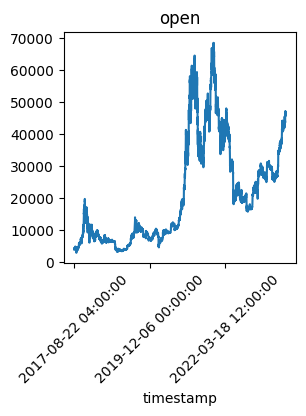

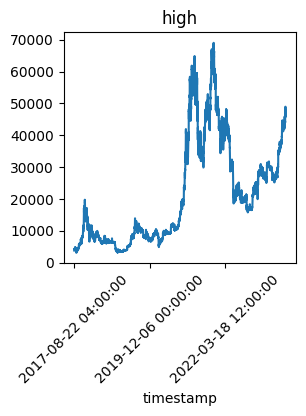

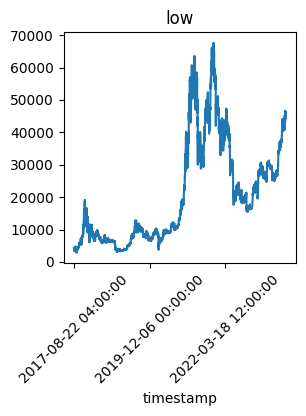

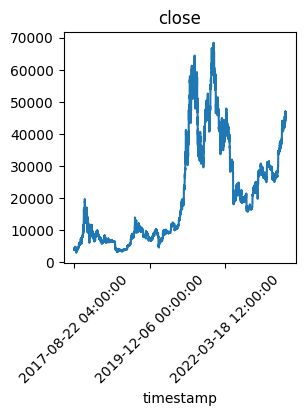

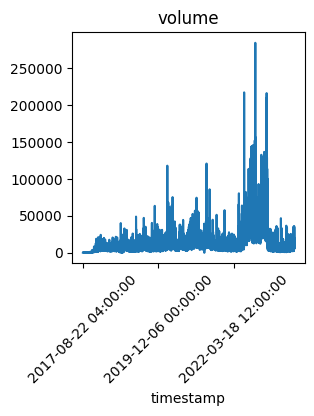

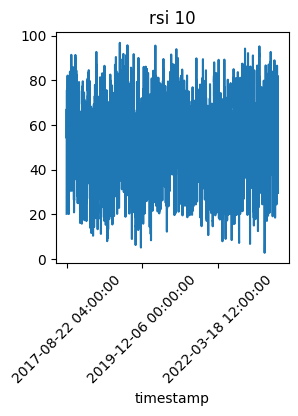

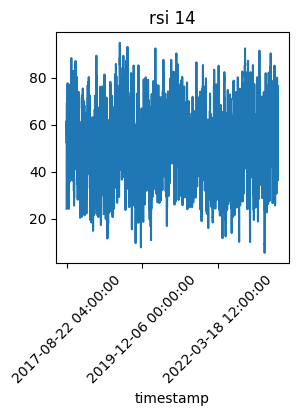

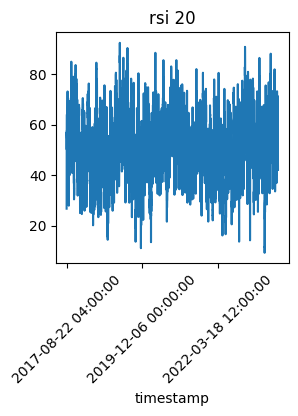

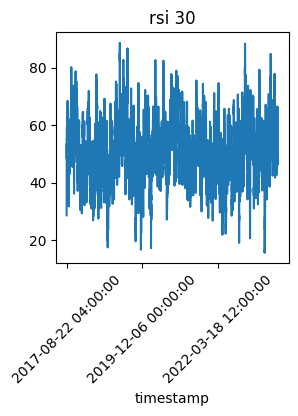

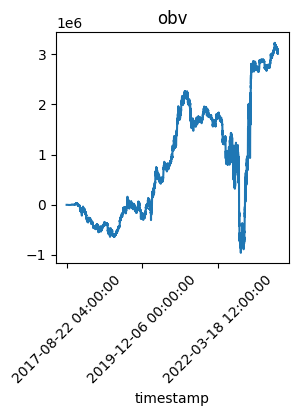

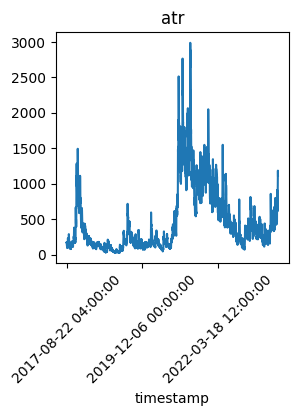

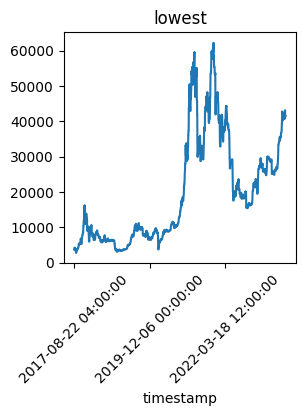

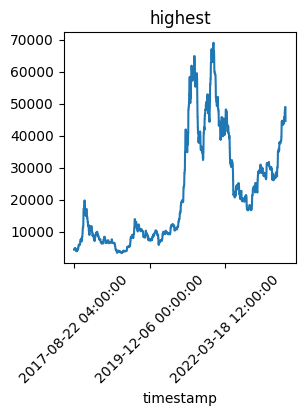

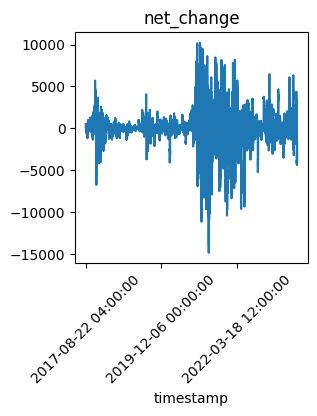

In [56]:
for i in df.drop(columns=["y"]):
    plt.figure(figsize = (3,3))
    df[i].plot(title = i)
    plt.xticks(rotation=45)
    
    plt.show()
   

In [ ]:
    
df.hist(bins =100,sharex = False,sharey=False,xlabelsize=1,ylabelsize=1,figsize=(10,10))
plt.show()

## Let's take a look at the distribution of y

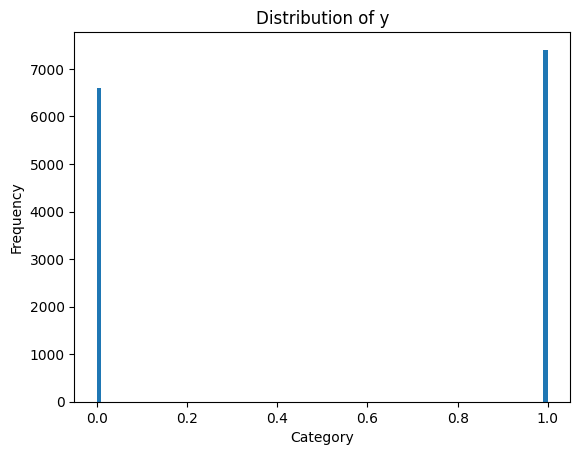

In [10]:
plt.hist(df["y"],100)
plt.title("Distribution of y")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.show()

## Check the correlation matrix and remove feature that dont add extra information

<Axes: title={'center': 'Correlation matrix'}>

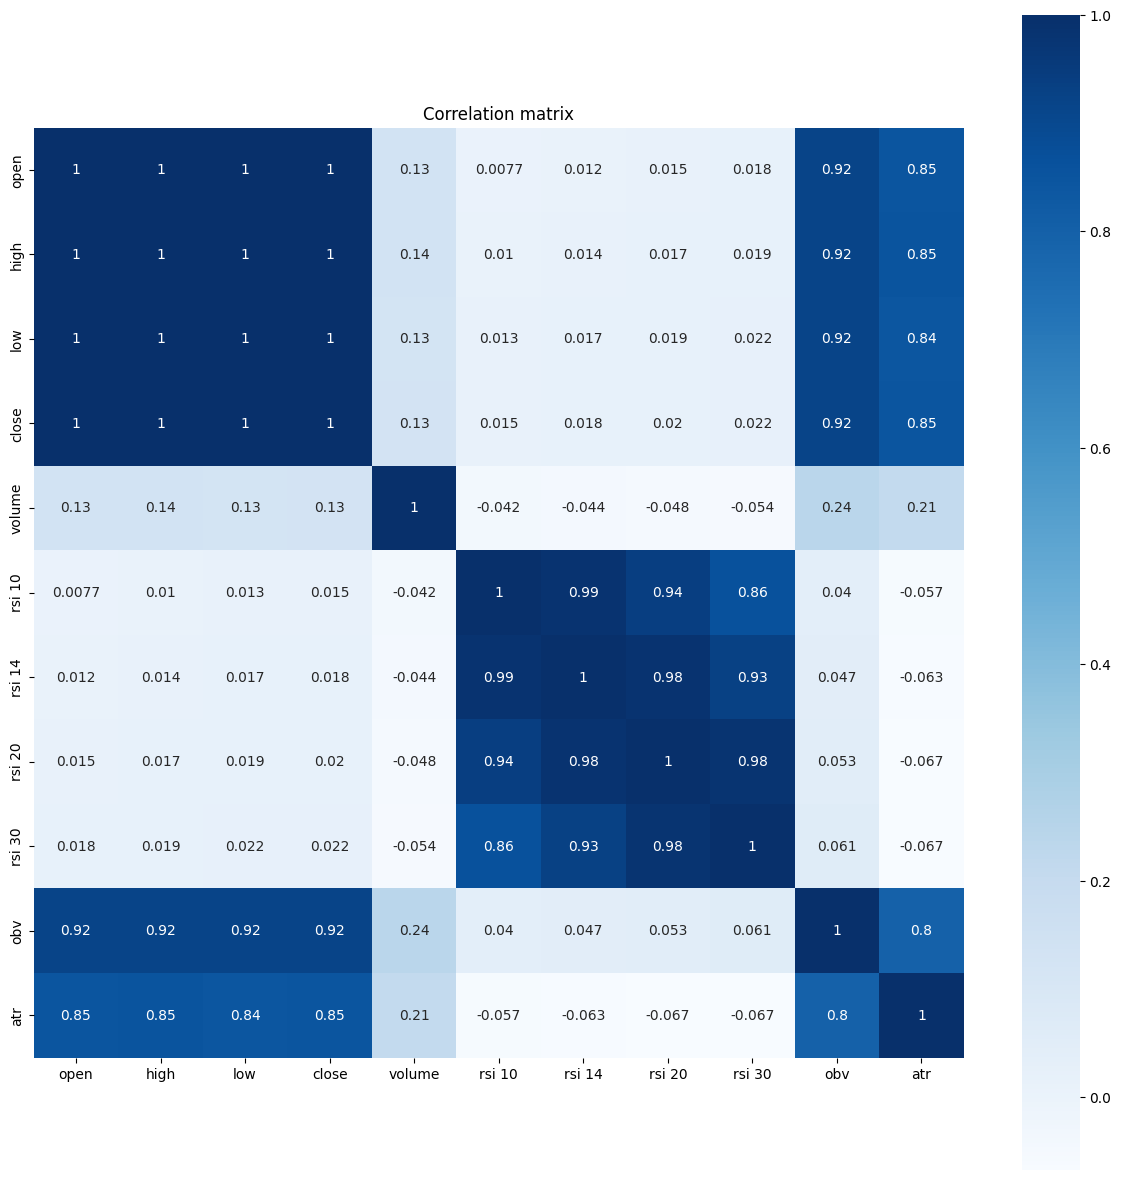

In [11]:
#correlation
correlation = X.corr()
plt.figure(figsize = (15,15))
plt.title("Correlation matrix")
sns.heatmap(correlation, vmax = 1, square = True,annot = True, cmap = "Blues")

# remove columns that overlap too muchin terms of correlation

# Set up the keras tuner for hyperparameter tuning

In [57]:


#create the model builder function
def build_model(hp):
    #create a sequential model
    model_3 = tf.keras.Sequential()

    #set up the options for hyper param tuning
    hp_activation = hp.Choice("activation", values = ["relu","sigmoid","tanh","swish","elu"])
    hp_learning_rate = hp.Choice("learning_rate", values = [0.0001,0.001,0.01,0.1])
    hp_reg_rate = hp.Choice("reg_rate", values = [0.0001,0.001,0.01,0.1])
    hp_regularizer = hp.Choice("regularizer", values = ["l1","l2","l1_l2"])
    hp_num_layers = hp.Int("num_layers",min_value=2,max_value=12)

    #for each number of layers option
    for i in range(hp_num_layers):
        #check regularizer type and set the variable
        if hp_regularizer == "l1":
            reg = regularizers.l1(hp_reg_rate)
        elif hp_regularizer == "l2":
            reg = regularizers.l2(hp_reg_rate)
        else:
            reg = regularizers.l1_l2(l1=hp_reg_rate, l2=hp_reg_rate)

        #add dense layer with tuning hyper parameters
        model_3.add(tf.keras.layers.Dense(
            units = hp.Int(f'layer_{i+1}_units', min_value=32, max_value=512, step=32),
            activation=hp_activation, kernel_regularizer = reg))
        
    #add the output layer
    model_3.add(tf.keras.layers.Dense(units = 1,activation = "sigmoid" ))

    #compile the model
    model_3.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), loss=BinaryCrossentropy(),metrics=["accuracy", Precision(), Recall(), AUC()])


    return model_3

#create a tuner instance
tuner = kt.Hyperband(build_model,
                     objective = "val_accuracy",
                     max_epochs = 50,
                     factor = 3,
                     directory = "dir",
                     project_name="x"
                     )
#set up early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss",
    patience = 15
)


## Set up time series split

### To prevent data leakage I have chosen time series split as a method of cross validation


In [18]:
#create a time series split instance and set the number of splits
tss = TimeSeriesSplit(n_splits = 20)

#create output list for evaluatin metrics
train_accuracy_output = []
cv_accuracy_output = []
test_accuracy_output = []

train_aoc_output = []
cv_aoc_output = []
test_aoc_output = []

train_precision_output = []
cv_precision_output = []
test_precision_output = []


train_recall_output = []
cv_recall_output = []
test_recall_output = []

#set the fold counter
fold = 1

#split test data in X and y removing any data leakage columns
X_test = test_df.drop(columns = ["highest","lowest","y","timestamp","net_change"], axis =1)

y_test = test_df["y"]

#set up the cross validation for loop and split train and cv by index
for train_index, test_index in tss.split(X):
    X_train, X_cv = X.iloc[train_index], X.iloc[test_index]
    y_train, y_cv = y.iloc[train_index], y.iloc[test_index]

    #create scaler and poly instance
    scaler = StandardScaler()
    poly = PolynomialFeatures(3)

    #apply poly fit and transformations
    X_train_poly = poly.fit_transform(X_train)
    X_cv_poly = poly.transform(X_cv)
    X_test_poly = poly.transform(X_test)

    
    #apply scaling and transormations
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_cv_scaled = scaler.transform(X_cv_poly)
    X_test_scaled = scaler.transform(X_test_poly)


    #fit the tuner to the scaled data of this loop iteration
    tuner.search(X_train_scaled,y_train, epochs= 50, validation_data = (X_cv_scaled,y_cv), callbacks = [stop_early])
    
    #store the best hyper parameters 
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    #create the best model using the best hyperparameters
    model_3 = tuner.hypermodel.build(best_hps)
    
    #train using the best model and store results in history
    history = model_3.fit(X_train_scaled,y_train,epochs = 200,verbose=2,callbacks = stop_early)

    #printout the results
    print(pd.DataFrame(history.history))

    #predictions
    predictions_train = model_3.predict(X_train_scaled)
    predictions_train_binary = (predictions_train > 0.5).astype(int)
    
    predictions_cv = model_3.predict(X_cv_scaled)
    predictions_cv_binary = (predictions_cv > 0.5).astype(int)
    
    predictions_test = model_3.predict(X_test_scaled)
    predictions_test_binary = (predictions_test > 0.5).astype(int)


    #calculate metrics
    train_accuracy = accuracy_score(y_train,predictions_train_binary)
    cv_accuracy = accuracy_score(y_cv,predictions_cv_binary)
    test_accuracy = accuracy_score(y_test,predictions_test_binary)
    
    train_aoc =roc_auc_score(y_train,predictions_train)
    cv_aoc = roc_auc_score(y_cv, predictions_cv)
    test_aoc = roc_auc_score(y_test, predictions_test)

    precision_train = precision_score(y_train, predictions_train_binary)
    precision_cv = precision_score(y_cv, predictions_cv_binary)
    precision_test = precision_score(y_test, predictions_test_binary)

    recall_train = recall_score(y_train, predictions_train_binary)
    recall_cv = recall_score(y_cv, predictions_cv_binary)
    recall_test = recall_score(y_test, predictions_test_binary)



    #append metric results to output lists
    train_accuracy_output.append(train_accuracy)
    cv_accuracy_output.append(cv_accuracy)
    test_accuracy_output.append(test_accuracy)

    train_aoc_output.append(train_aoc)
    cv_aoc_output.append(cv_aoc)
    test_aoc_output.append(test_aoc)

    train_recall_output.append(recall_train)
    cv_recall_output.append(recall_cv)
    test_recall_output.append(recall_test)

    train_precision_output.append(precision_train)
    cv_precision_output.append(precision_cv)
    test_precision_output.append(precision_test)
    
    #show progress and update counter
    print(f"Fold {fold} completed")
    fold +=1





#train outcomes mean value
print(f"Train accuracy NN: \n{np.mean(train_accuracy_output)}")
print(f"Train AOC NN: \n{np.mean(train_aoc_output)}")
print(f"Train precision NN: \n{np.mean(train_precision_output)}")
print(f"Train recall NN: \n{np.mean(train_recall_output)}")


#cv outcomes mean value
print(f"CV accuracy NN: \n{np.mean(cv_accuracy_output)}")
print(f"CV AOC NN: \n{np.mean(cv_aoc_output)}")
print(f"CV precision NN: \n{np.mean(cv_precision_output)}")
print(f"CV recall NN: \n{np.mean(cv_recall_output)}")



#test outcomes mean value
print(f"Test accuracy NN: \n{np.mean(test_accuracy_output)}")
print(f"Test AOC NN: \n{np.mean(test_aoc_output)}")
print(f"Test precision NN: \n{np.mean(test_precision_output)}")
print(f"Test recall NN: \n{np.mean(test_recall_output)}")



Epoch 1/200
18/18 - 3s - loss: 741.9253 - accuracy: 0.6757 - precision_21: 0.7166 - recall_21: 0.8407 - auc_21: 0.6292 - 3s/epoch - 174ms/step
Epoch 2/200
18/18 - 0s - loss: 719.1785 - accuracy: 0.6775 - precision_21: 0.7183 - recall_21: 0.8407 - auc_21: 0.6254 - 91ms/epoch - 5ms/step
Epoch 3/200
18/18 - 0s - loss: 696.8467 - accuracy: 0.6757 - precision_21: 0.7136 - recall_21: 0.8489 - auc_21: 0.6214 - 79ms/epoch - 4ms/step
Epoch 4/200
18/18 - 0s - loss: 674.9308 - accuracy: 0.6721 - precision_21: 0.7094 - recall_21: 0.8516 - auc_21: 0.6147 - 78ms/epoch - 4ms/step
Epoch 5/200
18/18 - 0s - loss: 653.4388 - accuracy: 0.6649 - precision_21: 0.6984 - recall_21: 0.8654 - auc_21: 0.6169 - 116ms/epoch - 6ms/step
Epoch 6/200
18/18 - 0s - loss: 632.3610 - accuracy: 0.6612 - precision_21: 0.6945 - recall_21: 0.8681 - auc_21: 0.6096 - 78ms/epoch - 4ms/step
Epoch 7/200
18/18 - 0s - loss: 611.7010 - accuracy: 0.6612 - precision_21: 0.6911 - recall_21: 0.8791 - auc_21: 0.6103 - 78ms/epoch - 4ms/ste

C:\Users\dariu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dariu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dariu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill

Epoch 1/200
117/117 - 2s - loss: 685.4781 - accuracy: 0.4757 - precision_27: 0.5060 - recall_27: 0.6155 - auc_27: 0.4511 - 2s/epoch - 17ms/step
Epoch 2/200
117/117 - 0s - loss: 552.1935 - accuracy: 0.4629 - precision_27: 0.4959 - recall_27: 0.5753 - auc_27: 0.4412 - 358ms/epoch - 3ms/step
Epoch 3/200
117/117 - 0s - loss: 435.5634 - accuracy: 0.4613 - precision_27: 0.4944 - recall_27: 0.5517 - auc_27: 0.4369 - 363ms/epoch - 3ms/step
Epoch 4/200
117/117 - 0s - loss: 334.8557 - accuracy: 0.4503 - precision_27: 0.4859 - recall_27: 0.5723 - auc_27: 0.4300 - 367ms/epoch - 3ms/step
Epoch 5/200
117/117 - 0s - loss: 249.4021 - accuracy: 0.4533 - precision_27: 0.4897 - recall_27: 0.6551 - auc_27: 0.4261 - 370ms/epoch - 3ms/step
Epoch 6/200
117/117 - 0s - loss: 178.6084 - accuracy: 0.4882 - precision_27: 0.5118 - recall_27: 0.8288 - auc_27: 0.4191 - 359ms/epoch - 3ms/step
Epoch 7/200
117/117 - 0s - loss: 121.9018 - accuracy: 0.5254 - precision_27: 0.5292 - recall_27: 0.9769 - auc_27: 0.4192 - 403

In [14]:
#run a soft max model in order to categories candles into 4 categories, strong buy, buy, sell ,strong sell

In [15]:
#run an alternative XGBoost model and compare results 

In [16]:
#add visualisation

In [17]:
#add regression to predict target